In [1]:
import matplotlib.pyplot as plt
import datasets as ds
import sklearn.datasets as skds

%load_ext autoreload
%autoreload 2

### simulate datasets for linear least squares

In [2]:
Xs_noise, ys_noise = ds.generate_datasets("noise", linear=True, noise=[0, 10, 100])
Xs_n_samples, ys_n_samples = ds.generate_datasets(
    "n_samples", linear=True, n_samples=[500, 1000, 10000]
)
Xs_n_features, ys_n_features = ds.generate_datasets(
    "n_features", linear=True, n_features=[3, 5, 200]
)


>>> noise


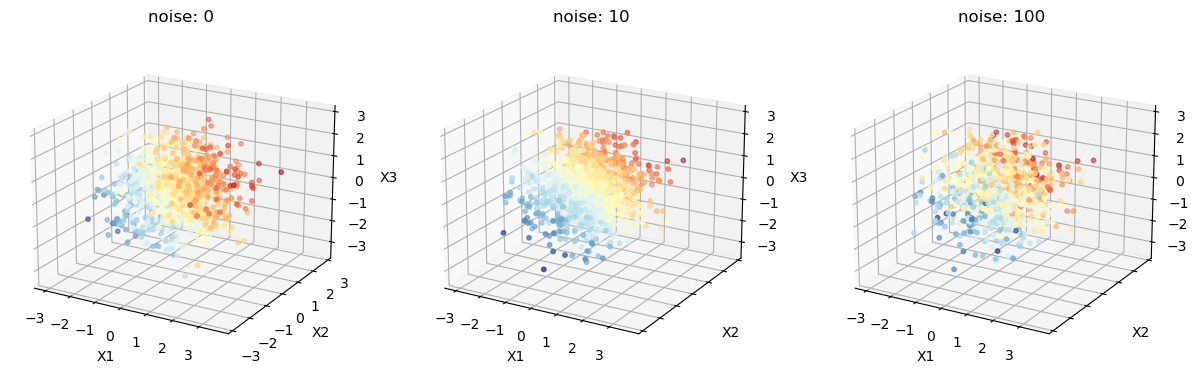

>>> n_samples


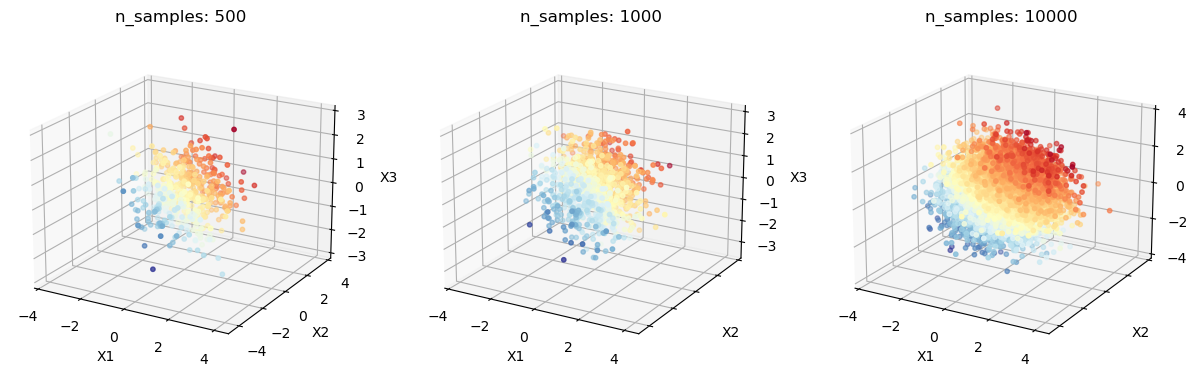

>>> n_features


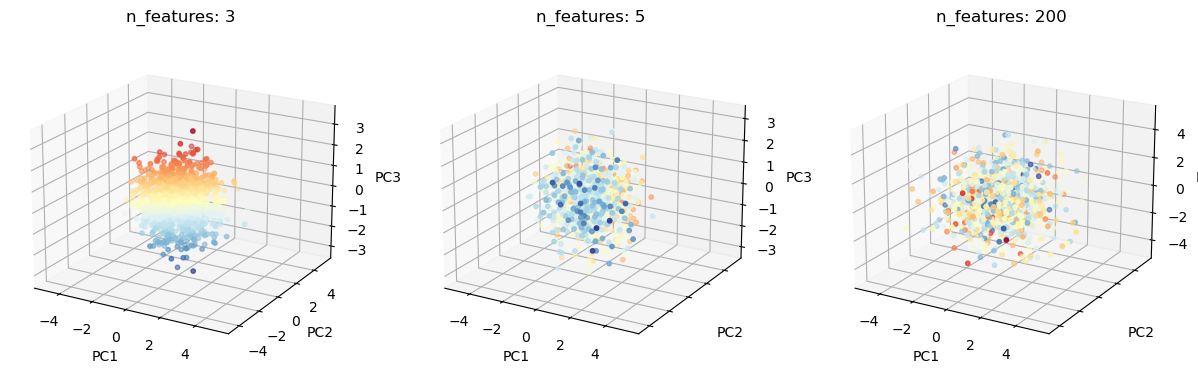

In [3]:
print(">>> noise")
ds.plot_3d_projection("noise", Xs_noise, ys_noise)
plt.show()

print(">>> n_samples")
ds.plot_3d_projection("n_samples", Xs_n_samples, ys_n_samples)
plt.show()

print(">>> n_features")
ds.plot_3d_projection("n_features", Xs_n_features, ys_n_features)
plt.show()


### simulate datasets for non-linear least squares

In [4]:
Xs_noise, ys_noise = ds.generate_datasets("noise", linear=False, noise=[0, 50, 100])
Xs_n_samples, ys_n_samples = ds.generate_datasets(
    "n_samples", linear=False, n_samples=[500, 1000, 10000]
)
Xs_n_features, ys_n_features = ds.generate_datasets(
    "n_features", linear=False, n_features=[5, 100, 200]
)


>>> noise


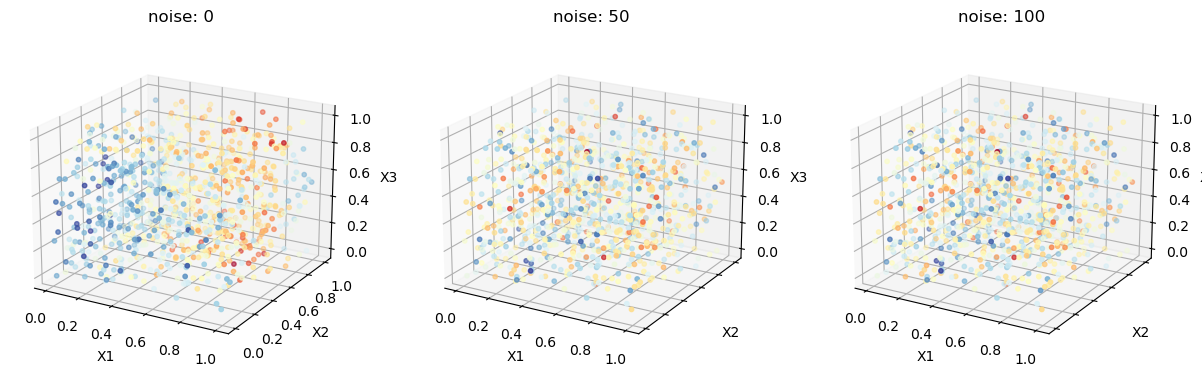

>>> n_samples


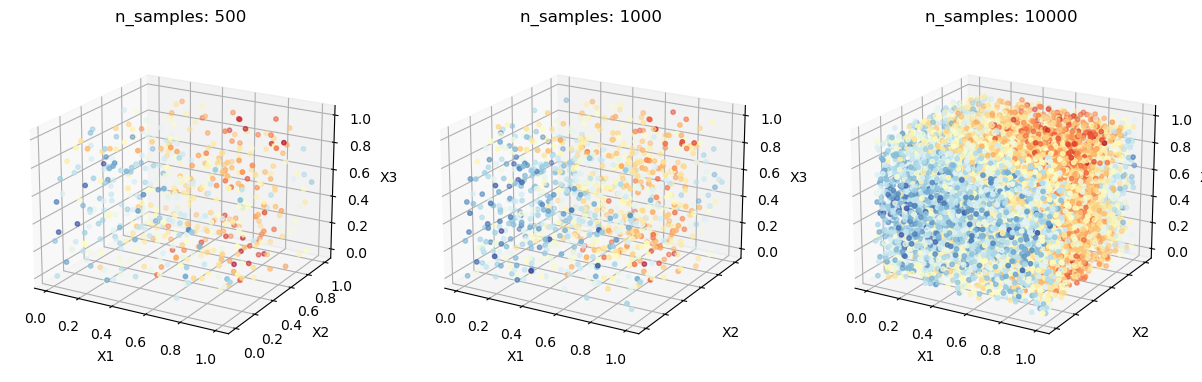

>>> n_features


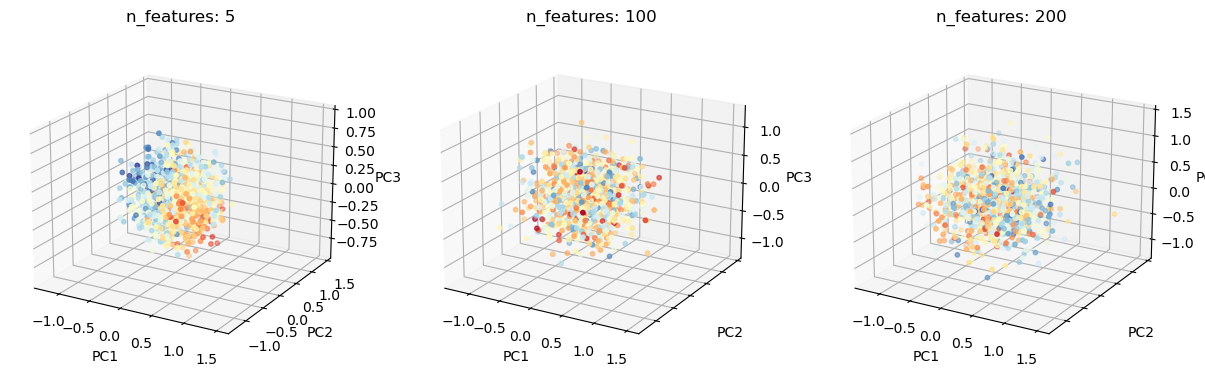

In [5]:
print(">>> noise")
ds.plot_3d_projection("noise", Xs_noise, ys_noise)
plt.show()

print(">>> n_samples")
ds.plot_3d_projection("n_samples", Xs_n_samples, ys_n_samples)
plt.show()

print(">>> n_features")
ds.plot_3d_projection("n_features", Xs_n_features, ys_n_features)
plt.show()


### toy dataset example

In [6]:
db = skds.load_diabetes(as_frame=True, scaled=True)
db_X = db.data
db_y = db.target
print("X =", *db_X.columns, "| y = ", "\n(n_samples, n_features) =", db_X.shape)


X = age sex bmi bp s1 s2 s3 s4 s5 s6 | y =  
(n_samples, n_features) = (442, 10)


Text(0.5, 0, 'S5')

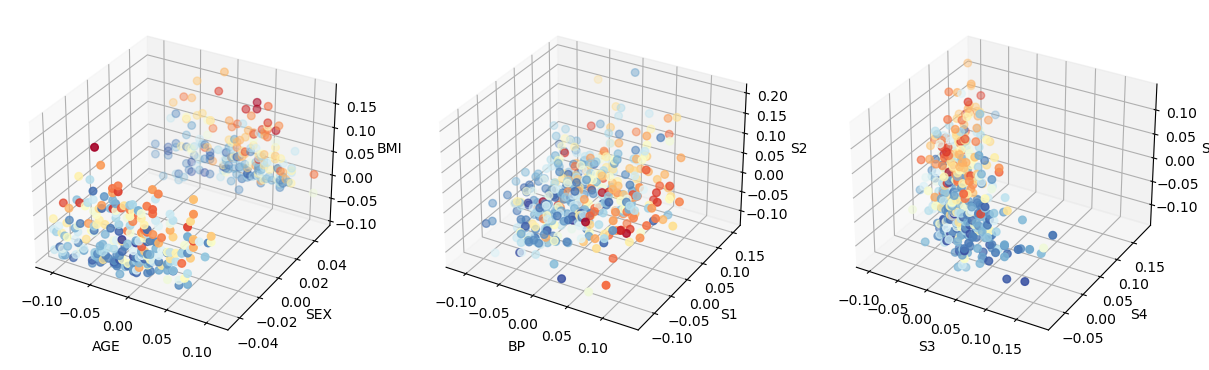

In [7]:
# marginal plots
fig, axs = plt.subplots(1, 3, figsize=(15, 10), subplot_kw=dict(projection="3d"))

cmap = "RdYlBu_r"
axs[0].scatter(db_X["age"], db_X["sex"], db_X["bmi"], c=db_y, s=30, cmap=cmap)
axs[0].set_xlabel("AGE")
axs[0].set_ylabel("SEX")
axs[0].set_zlabel("BMI")

axs[1].scatter(db_X["bp"], db_X["s1"], db_X["s2"], c=db_y, s=30, cmap=cmap)
axs[1].set_xlabel("BP")
axs[1].set_ylabel("S1")
axs[1].set_zlabel("S2")

ax = axs[2].scatter(db_X["s3"], db_X["s4"], db_X["s5"], c=db_y, s=30, cmap=cmap)
axs[2].set_xlabel("S3")
axs[2].set_ylabel("S4")
axs[2].set_zlabel("S5")
